In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import eurostat
import numpy as np
from tqdm import tqdm
from pmdarima.arima import auto_arima
import warnings
import pickle
import xgboost as xgb
from sklearn.metrics  import mean_squared_error as mse_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from sklearn.model_selection import GridSearchCV
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape_score
from sklearn.metrics import r2_score
from joblib import Parallel
from joblib import delayed
from os import cpu_count

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer, TimeDistributed
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

In [2]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]


# LSTM

In [3]:
def smooth(ts, w = 12):
    smoothts = ts.rolling(window=w).mean().dropna()
    return smoothts

def split(ts, p = 0.8):
    train = ts[:round(p*len(ts))]
    test = ts[round(p*len(ts)):]
    return train, test

In [4]:
ts = tsprod["Ethanol"]["DE"].Tons
ts = smooth(ts)
train, test = split(ts)
train.tail()

TIME_PERIOD
2016-02-01    78004.337167
2016-03-01    78230.437167
2016-04-01    78428.281917
2016-05-01    79256.266667
2016-06-01    78222.831083
Name: Tons, dtype: float64

In [5]:
tsprod["Ethanol"]["DE"].Price

TIME_PERIOD
1988-01-01     537.089447
1988-02-01     479.691552
1988-03-01     530.828307
1988-04-01     512.240225
1988-05-01     483.517450
                 ...     
2023-01-01    1117.564392
2023-02-01    1167.000745
2023-03-01    1298.289840
2023-04-01    1186.485003
2023-05-01    1052.608285
Name: Price, Length: 425, dtype: float64

### Experiment

In [47]:
def df_to_X_y(df, window_size = 24):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

df = tsprod["Ethanol"]["DE"]

window_size = 12 
period_test = int(0.2*len(df))

scaler = MinMaxScaler()
X, y = df_to_X_y(scaler.fit_transform(df.Price.values.reshape(-1,1)), window_size= window_size)

X_train, y_train = X[:-2*period_test], y[:-2*period_test]
X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
X_test, y_test = X[-period_test:], y[-period_test:]
#print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64, input_shape=(window_size, 1), return_sequences=True))
model.add(LSTM(64,input_shape=(window_size, 1)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

#cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50
           #,callbacks=[cp]
           , verbose=None
          )

train_predictions = model.predict(X_train, verbose=None)
train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
val_predictions = model.predict(X_val, verbose=None)
val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
test_predictions = model.predict(X_test, verbose=None)
test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)

## Out of Sample Forecast

# Example: Forecasting 100 future time steps
num_forecast_steps = 135

# Create an empty list to store the forecasted values
forecasted_values = []

# Initialize the last known window (X_t) with the last window from the test data
last_known_window = X_test[-1:]

# Perform forecasting for each time step
for i in range(num_forecast_steps):
    # Use the last known window to predict the next time step
    prediction = model.predict(last_known_window, verbose=None)
    
    # Append the forecasted value to the list
    forecasted_values.append(prediction[0, 0])
    
    # Update the last known window (X_t) with the current prediction and shift the window
    last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)


forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))
forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                            #,"Lower_CI" : lower_bound_values.flatten()[1:]
                            #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                           })

forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))

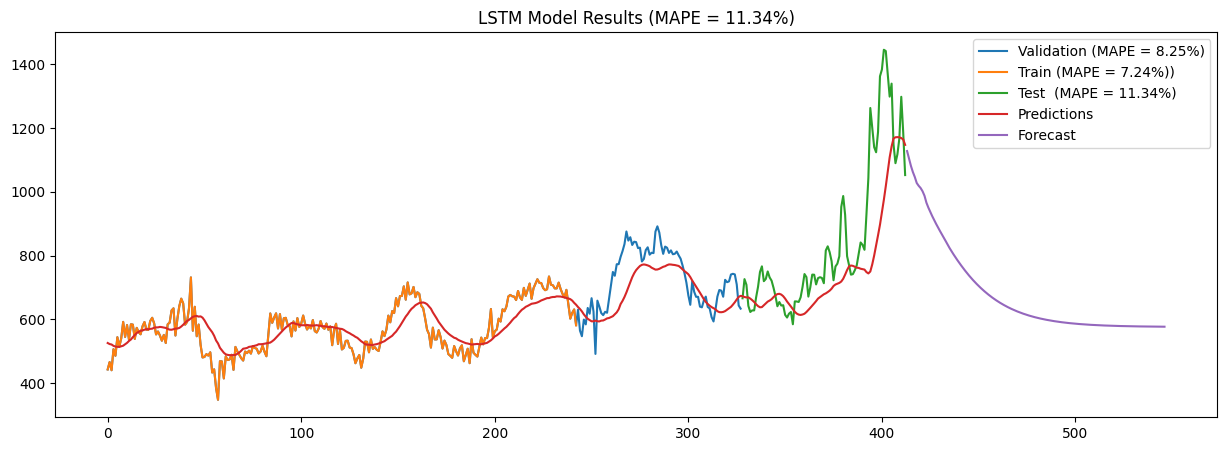

In [48]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%))")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test  (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
ax.plot(forecast_df.index, forecast_df.Forecast, label = "Forecast")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {test_mape}%)")
plt.show()

# Generalization

In [162]:
def df_to_X_y(df, window_size = 24, smooth = None):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)



def run_lstm(
        ts, 
        window_size = 12, 
        ptest = 0.2,
        hidden_units = 64,
        dense_units = 8,
        smooth = None,
        sth_window = 12
        ):
    period_test = int(ptest*len(ts))

    scaler = MinMaxScaler()
    X, y = df_to_X_y(scaler.fit_transform(ts.values.reshape(-1,1)), window_size= window_size)

    t = 0
    if smooth is not None:
        X, y_smooth =  df_to_X_y(scaler.fit_transform(smooth.values.reshape(-1,1)), window_size= window_size)
        period_test = int(ptest*len(smooth))
        t = sth_window - 1

    X_train, y_train = X[:-2*period_test], y[t:-2*period_test]
    X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
    X_test, y_test = X[-period_test:], y[-period_test:]
    #print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    model = Sequential()
    model.add(InputLayer((window_size, 1)))
    model.add(LSTM(hidden_units, input_shape=(window_size, 1), return_sequences=True))
    model.add(LSTM(hidden_units,input_shape=(window_size, 1)))
    model.add(Dense(dense_units, 'relu'))
    #model.add(TimeDistributed(Dense(10)))
    model.add(Dense(1, 'linear'))

    #cp = ModelCheckpoint('model/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50
            #,callbacks=[cp]
            , verbose=None
            )

    train_predictions = model.predict(X_train, verbose=None)
    train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
    train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
    train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
    val_predictions = model.predict(X_val, verbose=None)
    val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
    val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
    val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
    test_predictions = model.predict(X_test, verbose=None)
    test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
    test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
    test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
    lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)

    ## Out of Sample Forecast

    # Example: Forecasting 100 future time steps
    num_forecast_steps = 135

    # Create an empty list to store the forecasted values
    forecasted_values = []

    # Initialize the last known window (X_t) with the last window from the test data
    last_known_window = X_test[-1:]

    # Perform forecasting for each time step
    for i in range(num_forecast_steps):
        # Use the last known window to predict the next time step
        prediction = model.predict(last_known_window, verbose=None)
        
        # Append the forecasted value to the list
        forecasted_values.append(prediction[0, 0])
        
        # Update the last known window (X_t) with the current prediction and shift the window
        last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)


    forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))
    forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                                #,"Lower_CI" : lower_bound_values.flatten()[1:]
                                #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                            })

    forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))

    results = {}
    results["train"] = lstm_df[:-period_test].Actuals
    results["val"] = lstm_df[:-2*period_test].Actuals
    results["test"] = lstm_df[-period_test:].Actuals
    results["predictions"] = lstm_df.Prediction
    results["forecast"] = forecast_df.Forecast
    results["train_mape"]=train_mape
    results["val_mape"]=val_mape
    results["test_mape"]=test_mape
    return results

In [222]:
p = "Ethanol"
geo = "NL"
field = "Tons"
ts = tsprod[p][geo][field]
window_size = 12
ptest = 0.2
smt_window = 12
res = run_lstm(ts, window_size, ptest=ptest #dense_units= 8
               #, hidden_units = 120
               #, smooth = smooth(ts, smt_window), sth_window=smt_window
               )

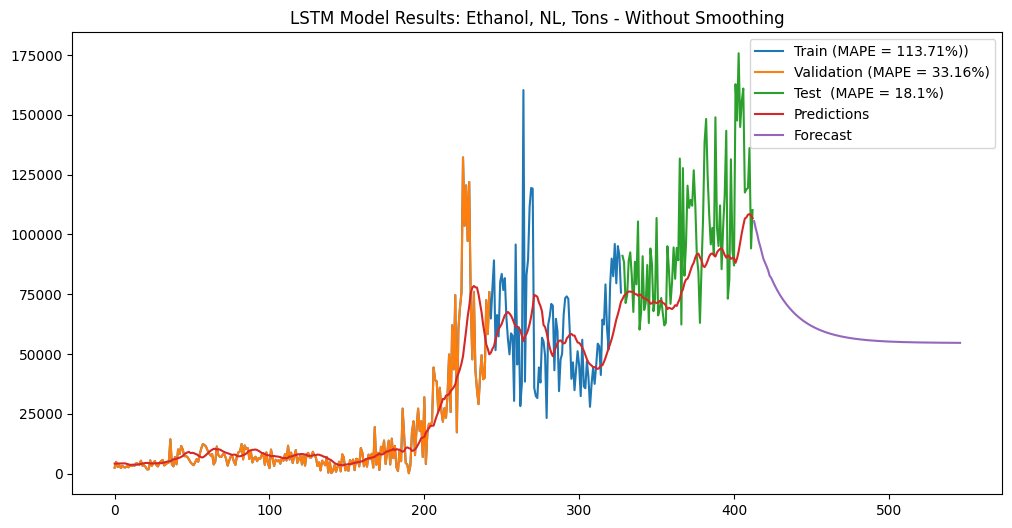

In [224]:


def plot_res(res, p, geo, field):
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(res["train"].index,res["train"].values, label = f"Train (MAPE = {res['train_mape']}%))")
    ax.plot(res["val"].index,res["val"].values, label = f"Validation (MAPE = {res['val_mape']}%)")
    ax.plot(res["test"].index,res["test"].values, label = f"Test  (MAPE = {res['test_mape']}%)")
    ax.plot(res["predictions"].index,res["predictions"].values, label = "Predictions")
    ax.plot(res["forecast"].index,res["forecast"].values, label = "Forecast")
    plt.legend()
    plt.title(f"LSTM Model Results: {p}, {geo}, {field} - Without Smoothing")
    plt.show()
plot_res(res, p, geo, field)

In [215]:
res["forecast"].tail()

519    583.948608
520    583.948547
521    583.948608
522    583.948608
523    583.948608
Name: Forecast, dtype: float32

In [216]:
res["forecast"] = res["forecast"] * 2
lstm_results_prods[p,geo,field] = res
lstm_results_prods_price[p][geo] = res

In [217]:
with open(f'lstm_results_prods_tons.pickle', 'wb') as f:
    pickle.dump(lstm_results_prods_tons, f)
with open(f'lstm_results_prods_price.pickle', 'wb') as f:
    pickle.dump(lstm_results_prods_price, f)
with open(f'lstm_results_prods.pickle', 'wb') as f:
    pickle.dump(lstm_results_prods, f)

In [19]:
window_size = 12 
ptest = 0.2
#lstm_results_prods_price = {}
#lstm_results_prods_tons = {}
#lstm_results_prods = {}
for p in tsprod.keys():
 #   lstm_results_prods_price[p] = {}
  #  lstm_results_prods_tons[p] = {}
    for geo in tsprod[p].keys():
        for field in tqdm(["Tons", "Price"]):
            ts = tsprod[p][geo][field]
            res = run_lstm(ts, window_size)
            #lstm_results_prods[p,geo,field] = res
            #if field == "Price":
             #   lstm_results_prods_price[p][geo] = res
            #elif field == "Tons":
             #   lstm_results_prods_tons[p][geo] = res

100%|██████████| 2/2 [00:28<00:00, 14.17s/it]


In [225]:
@interact
def interact_plots(Dataset = list(lstm_results_prods.keys())):
    res = lstm_results_prods[Dataset]
    p, geo, field = Dataset
    #print(res["forecast"].tail())
    plot_res(res, p, geo, field)

interactive(children=(Dropdown(description='Dataset', options=(('LA', 'BE', 'Tons'), ('LA', 'BE', 'Price'), ('…

In [46]:
for dataset in lstm_results_prods.keys():
    print(dataset, lstm_results_prods[dataset]["test_mape"])

('LA', 'BE', 'Tons') 15.54
('LA', 'BE', 'Price') 11.59
('LA', 'DE', 'Tons') 9.49
('LA', 'DE', 'Price') 8.15
('LA', 'NL', 'Tons') 46.61
('LA', 'NL', 'Price') 25.57
('Ethanol', 'DE', 'Tons') 16.0
('Ethanol', 'DE', 'Price') 10.78
('Ethanol', 'FR', 'Tons') 33.97
('Ethanol', 'FR', 'Price') 44.3
('Ethanol', 'NL', 'Tons') 50.98
('Ethanol', 'NL', 'Price') 26.27
('SA', 'DE', 'Tons') 18.53
('SA', 'DE', 'Price') 18.95
('SA', 'IT', 'Tons') 24.03
('SA', 'IT', 'Price') 17.09
('SA', 'NL', 'Tons') 21.62
('SA', 'NL', 'Price') 15.48


In [45]:
with open(f'lstm_results_prods_tons.pickle', 'wb') as f:
    pickle.dump(lstm_results_prods_tons, f)
with open(f'lstm_results_prods_price.pickle', 'wb') as f:
    pickle.dump(lstm_results_prods_price, f)
with open(f'lstm_results_prods.pickle', 'wb') as f:
    pickle.dump(lstm_results_prods, f)

In [40]:
with open(f'lstm_results_prods_tons.pickle', 'rb') as f:
    lstm_results_prods_tons = pickle.load(f)
with open(f'lstm_results_prods_price.pickle', 'rb') as f:
    lstm_results_prods_price = pickle.load(f)

lstm_results_prods = {}
for p in lstm_results_prods_tons.keys():
    for geo in lstm_results_prods_tons[p].keys():
        lstm_results_prods[p, geo, "Tons"] = lstm_results_prods_tons[p][geo]
        lstm_results_prods[p, geo, "Price"] = lstm_results_prods_price[p][geo]        

In [12]:
window_size = 12 
ptest = 0.2
lstm_results_feed_price = {}
lstm_results_feed = {}
for p in tsfeed.keys():
    lstm_results_feed_price[p] = {}
    for geo in tqdm(tsfeed[p].keys()):
        ts = tsfeed[p][geo].Price
        res = run_lstm(ts, window_size, hidden_units=64, dense_units=16)
        lstm_results_feed[p,geo,"Price"] = res
        lstm_results_feed_price[p][geo] = res


100%|██████████| 3/3 [00:48<00:00, 16.29s/it]


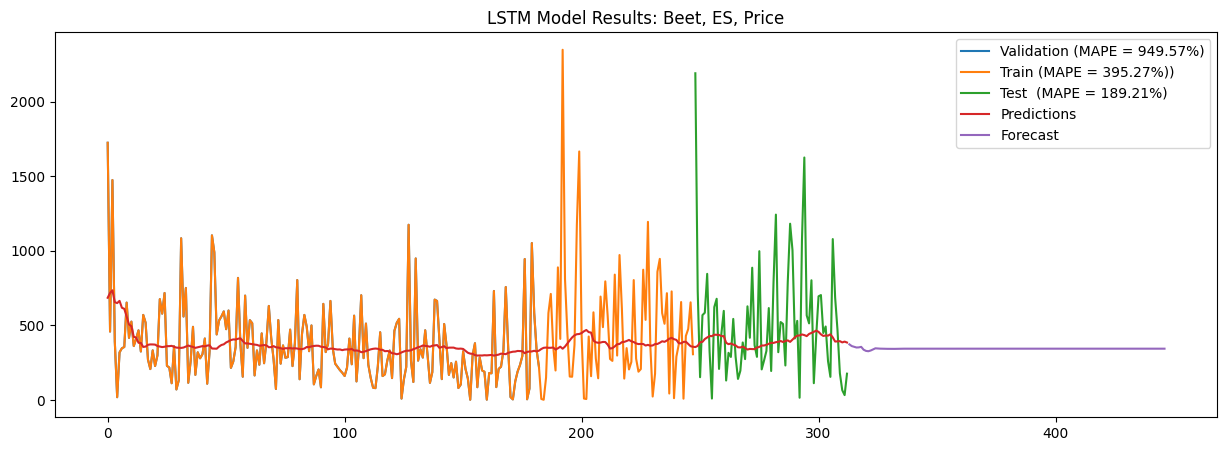

In [28]:
p = "Beet"
geo = "ES"
window_size = 12 
ptest = 0.2
ts = tsfeed[p][geo].Price
ts = ts[100:]
res = run_lstm(ts, window_size, hidden_units=64, dense_units=16)
plot_res(res, p, geo, "Price")

In [29]:
lstm_results_feed[p,geo,"Price"] = res
lstm_results_feed_price[p][geo] = res

In [34]:
@interact
def interact_plots(Dataset = list(lstm_results_feed.keys())):
    res = lstm_results_feed[Dataset]
    p, geo, field = Dataset
    #print(res["forecast"][-5:])
    plot_res(res, p, geo, field)

interactive(children=(Dropdown(description='Dataset', options=(('Maize', 'BE', 'Price'), ('Maize', 'ES', 'Pric…

In [31]:
with open(f'lstm_forecast_feed.pickle', 'wb') as f:
    pickle.dump(lstm_results_feed_price, f)